<a href="https://colab.research.google.com/github/Raghuram-Veeramallu/Astro_Stat_Project2/blob/development/Project2_Group3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AST/STAT 5731 Project 2
## Research Synopsis
**Group 3**   
Daniel Warshofsky  
Hari Veeramallu  
Jacynda Alatoma  
Nicholas Kruegler

### Research Question

What is the value of Hubble's constant as found from a linear regression of the redshifts and distances of Type Ia supernovae within a redshift of 0.1?

In [1]:
# load data for this instance
!gdown 1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0

Downloading...
From: https://drive.google.com/uc?id=1v6LSAKvkuEjahtOWDNq3riBMLkD7rZD0
To: /content/snaeT1.tsv
100% 47.4k/47.4k [00:00<00:00, 56.8MB/s]


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pymc as pm
import arviz as az

In [3]:
## setting the theme for the grid
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [4]:
df = pd.read_csv('/content/snaeT1.tsv',sep='\t')

In [5]:
df.head(10)

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst
0,0.503,0.5043,23.002,0.088,1.273,0.150,-0.012,0.030,9.517
1,0.581,0.5820,23.574,0.090,0.974,0.274,-0.025,0.037,9.169
2,0.495,0.4960,22.960,0.088,-0.729,0.102,-0.100,0.030,11.580
3,0.346,0.3470,22.398,0.087,-1.155,0.113,-0.041,0.027,10.821
4,0.678,0.6790,24.078,0.098,0.619,0.404,-0.039,0.067,8.647
5,0.611,0.6120,23.285,0.093,-1.162,1.641,-0.095,0.050,9.715
6,0.866,0.8680,24.354,0.106,0.376,0.348,-0.063,0.068,8.530
7,0.331,0.3320,21.861,0.086,0.650,0.119,-0.018,0.024,10.391
8,0.799,0.8000,24.510,0.102,-1.057,0.407,-0.056,0.065,10.651
9,0.450,0.4490,22.667,0.092,0.810,0.232,-0.086,0.038,10.695


**Column Description:**.

| Column  | Description                 |
| ------- | --------------------------- |
| zcmb    | CMB Frame Redshift          |
| zhel    | Heliocentric Redshift       |
| mb      | B band peak magnitude (in mB)|
| e_mb    | Error in mb                 |
| x1      | SALT2 shape (stretch) parameter |
| e_x1    | Error in x1                 |
| c       | SALT2 color parameter       |
| e_c     | Error in c                  |
| logMst  | $Log_{10}$ Host Stellar Mass|

### **Processing Data**

Since we want to estimate the relationship between the Distance and the Redshift (CMB), we need to compute the distance from the parameters that we have available to us.

Distance can be computed through Distance Modulii $\mu$, defined as
$$ \mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$$
where,  
$m_{B}^{*}$ is the observed peak magnitude in rest frame B band.  
$M_{B}$ is the absolute magnitude of the supernova (adjusted based on host galaxy's properties). It depends on the host galalxy's stellar mass ($M_{stellar}$).   
$$M_{B} = \begin{cases} M_{B}^{1} & \text{if $M_{stellar} < 10^{10} M_{\odot}$} \\
M_{B}^{1} + \Delta_{m} & \text{otherwise}
\end{cases}$$   
here, $M_{\odot}$ is the mass of the Sun.   
$\alpha, \beta$ are the nuisance parameters that account for the shape of the light curve ($X_{1}$) and the color of the supernova ($C$) respectively.  
$\beta, M_{B}$ are found to be dependent on the host galaxy properties.  

Modulus can be converted into distance (in parsec) using $ d_{L} = 10^{\mu/5 + 1} $.

($\mu = 5 log_{10}{(d_{L} /10 \,\mathrm{pc})}$ according to the literature[[1](https://www.aanda.org/articles/aa/pdf/2014/08/aa23413-14.pdf)]).

Since there are errors associated with each measurement, we need to estimate the distance errors as well.   

Error parameter $\sigma_{\mu}$ = $\sqrt{\sigma_{m_{b}}^{2} + (\alpha \sigma_{X_{1}})^2 + (\beta \sigma_{C})^2}$.  
where $\sigma_{m_{b}}, \sigma_{X_{1}}, \sigma_{C}$ refer to the error terms of $m_{b}, X_{1}$ and $C$ (`e_mb`, `e_x1` and `e_c` from the dataset).  

From the literature the values used are, $\alpha = 0.141, \beta = 3.101, M_{B}^{1} = -19.05$ and $\Delta_{M} = -0.07$ (according to the C11 analysis)

In [33]:
# defining the nuisance parameters
alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

#picking out data within z=0.1
data = df[df["zcmb"]<0.1].copy()

# MB
data['MB'] = MB1 + (DeltaM * (data['logMst'] > 10))

# mu
data['dist_moduli'] = data['mb'] - (data['MB'] - alpha * data['x1'] + beta * data['c'])

# distance
data['d'] = 10 ** (data['dist_moduli']/5 + 1) * 10**(-6) #converting to Mpc

# distance modulii (mu) error
data['e_mu'] = np.sqrt(data['e_mb'] ** 2 + (alpha * data['e_x1']) ** 2 + (beta * data['e_c']))

# distance error
data['e_d']= (data['e_mu'] * np.log(10) * np.abs(data['d']))/5

In [34]:
data.head(10)

,zcmb,zhel,mb,e_mb,x1,e_x1,c,e_c,logMst,MB,dist_moduli,d,e_mu,e_d
246,0.064,0.0653,18.348,0.113,-1.202,0.187,0.010,0.025,10.531,-19.12,37.267508,284.119865,0.301644,39.467739
249,0.044,0.0454,17.532,0.115,-0.953,0.402,0.057,0.025,9.998,-19.05,36.270870,179.545283,0.306534,25.345320
254,0.089,0.0902,19.115,0.113,-0.548,0.079,0.049,0.023,10.171,-19.12,38.005783,399.168811,0.290200,53.345745
256,0.079,0.0799,19.150,0.118,-0.561,0.261,0.096,0.030,10.590,-19.12,37.893203,379.001213,0.329102,57.440364
257,0.083,0.0843,19.386,0.115,-1.832,0.188,0.036,0.027,10.955,-19.12,38.136052,423.848255,0.312497,60.996175
266,0.080,0.0810,19.020,0.112,-0.069,0.085,0.070,0.021,10.081,-19.12,37.913201,382.507716,0.278942,49.136000
270,0.081,0.0827,18.916,0.112,-0.332,0.061,-0.005,0.020,9.793,-19.05,37.934693,386.312357,0.273200,48.603127
312,0.044,0.0454,17.546,0.114,-0.162,0.047,0.091,0.023,10.513,-19.12,36.360967,187.151538,0.290453,25.033114
315,0.057,0.0578,17.780,0.122,0.864,0.782,0.028,0.032,9.930,-19.05,36.864996,236.047389,0.355350,38.627923
383,0.096,0.0970,19.773,0.113,-2.310,0.224,0.070,0.025,9.507,-19.05,38.280220,452.943467,0.302145,63.023856


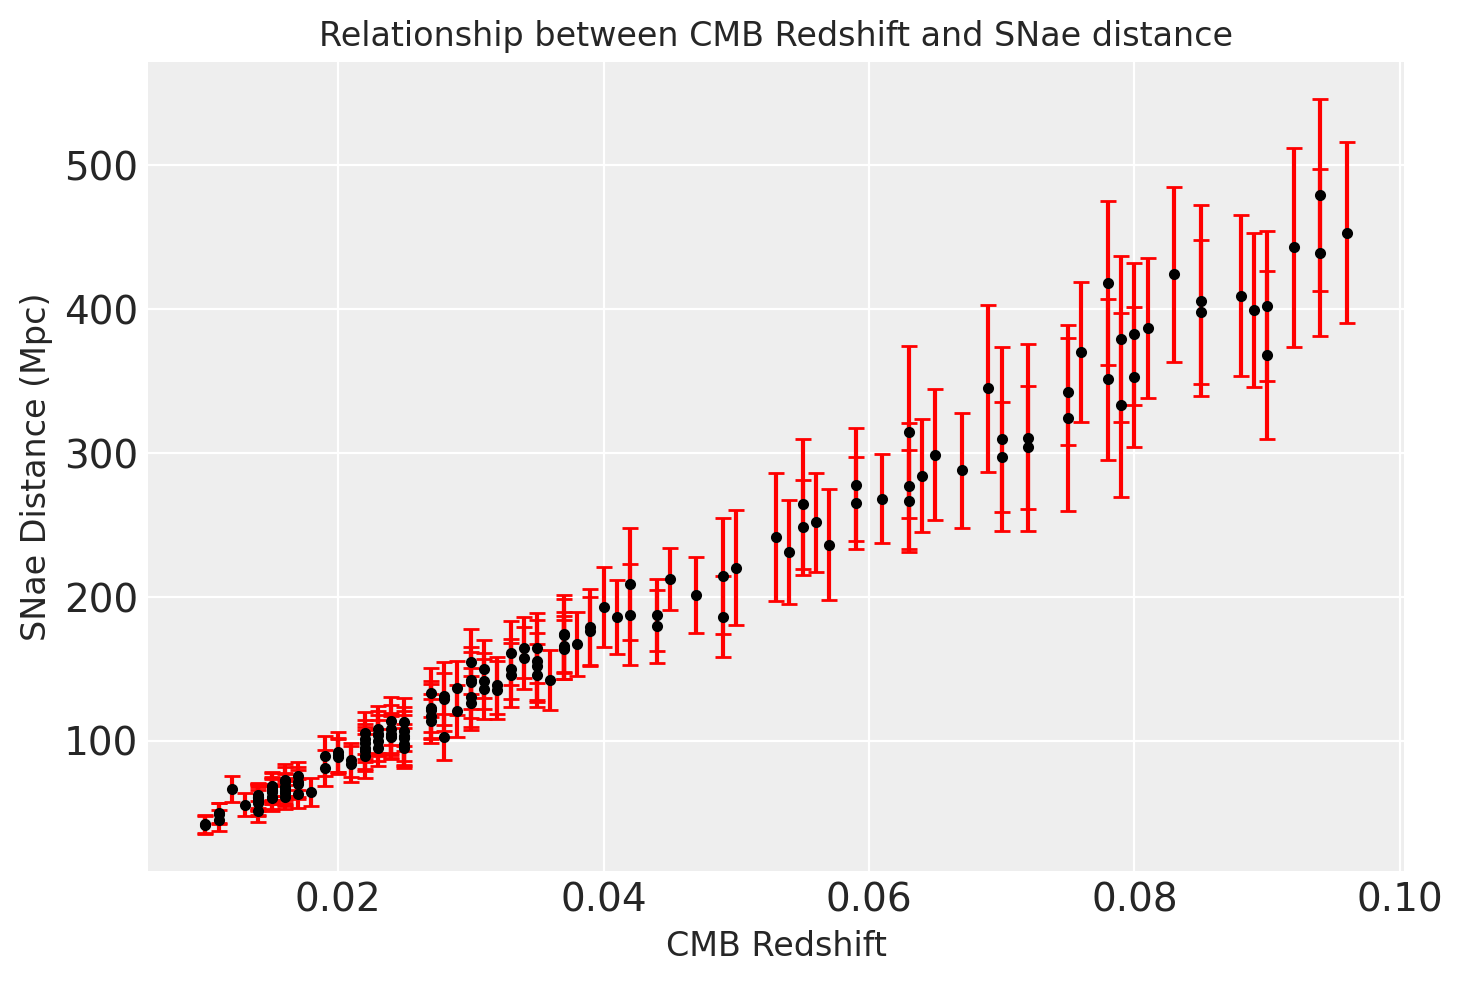

In [35]:
plt.errorbar(data['zcmb'], data['d'],yerr=data['e_d'],fmt="k.",ecolor="r",capsize=3)
plt.xlabel('CMB Redshift', size=12)
plt.ylabel('SNae Distance (Mpc)', size=12)
plt.title('Relationship between CMB Redshift and SNae distance', size=12)
plt.show()

### **Statistical Model**  

1. $x$, the redshift of the SNae
2. $X=(0,0.1]$, the set of all redshift values less than 0.1
3. Observed distance (in Mpc), $y=[41.2,479.1]$ (data described above)
4. Sample space, $Y = \mathbb{R}_+^{n}$  
5. The likelihood for our normal regression is $$Y|X,\beta,\tau \sim N(x_i\beta,\tau^{-1})$$
where $x_i\beta$ is the linear regression model $x_i\beta = H_0d$, the response $Y=cz$ is the speed of light $c$ times the redshift $z$, the distance $d$ is $d=10^{\mu/5+1}$, and the modulus is $\mu = m_{B}^{*} - (M_{B} - \alpha X_{1} + \beta C)$

6. We are extending the definition for the independence prior model where we assume $\nu(\beta, \tau) = \nu(\beta)\nu(\tau)$. The priors for our model parameters are defined as $$X\sim N(0,1000)$$ $$\beta \sim N(0,1000)$$  $$\tau \sim \mathrm{Gamma}(0.5,0.5)$$
which involve standard choices for the hyperparameters of the normal and gamma distributions.


In [40]:
#full model
z = data["zcmb"]
velocity = z*(3e8)
dist_mod = data["dist_moduli"]
dist_mod_err = data["e_mu"]

alpha = 0.141
beta = 3.101
MB1 = -19.05
DeltaM = -0.07

with pm.Model() as model:
    #Define data
    x=pm.MutableData('x',data['x1'])
    c=pm.MutableData('c',data['c'])
    mb=pm.MutableData('mb',data['mb'])
    MB=pm.MutableData('MB',data['MB'])

    #define H0
    H0 = pm.Normal("H0",mu=0,tau=1/1000)
    p= pm.Gamma('precision', alpha=1, beta=1)

    X = pm.Normal("X",mu=0,tau=1/1000)
    X_obs = pm.Normal("X_obs",mu=X,tau=1/data['e_x1']**2,observed=x,shape=len(data['x1']))

    C = pm.Normal("C",mu=0,tau=1/1000)
    C_obs = pm.Normal("C_obs",mu=C,tau=1/data['e_c']**2,observed=c,shape=len(data['c']))

    m = pm.Normal("m",mu=0,tau=1/1000)
    m_obs = pm.Normal('m_obs',mu=m,tau=1/data['e_mb']**2,observed=mb,shape=len(data['mb']))

    #define modulus model with measurement error
    distance_mod = pm.Deterministic("distance_mod", m - (MB - alpha * X + beta * C))
    distance = pm.Deterministic("distance",10**(distance_mod/5+1))

    #define response
    Y = pm.Normal("velocity",mu=H0*distance,tau=1/1000,observed=velocity)

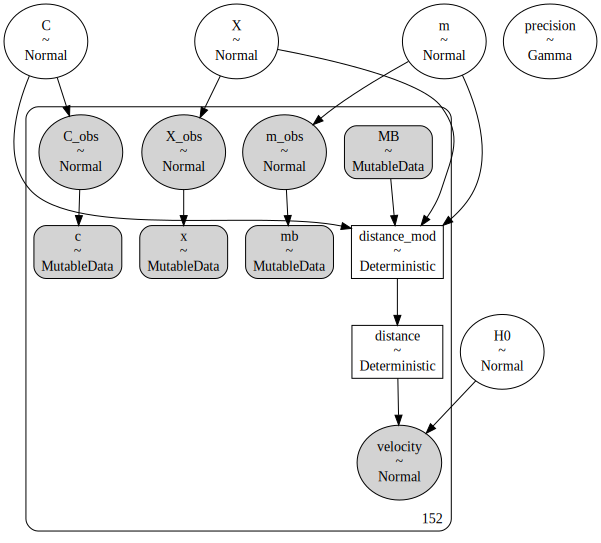

In [41]:
pm.model_to_graphviz(model)

In [42]:
#find minimum sample size
from scipy.stats import chi2
from scipy.special import gamma

def minESS(p,alpha=0.05,epsilon=0.05):
    X2=chi2.ppf(1-alpha, p)
    min_num=np.rint(np.pi*(2./p/gamma(p/2))**(2/p)*X2/epsilon**2)
    return min_num.astype(int)

#one parameters of beta so we have 3 degrees of freedom
N_sample = minESS(3).astype(int)

print('Minimum effective size:', N_sample)

Minimum effective size: 8123


In [43]:
with model:
  trace = pm.sample(9000)

ValueError: ignored